In [1]:
# Переходим к работе с данными. Импортируем модули, которые нам понадобятся:

import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
%matplotlib inline

In [2]:
# Прочитаем данные о собранных образцах воды и выведем первые пять строк таблицы:

water_data = pd.read_csv('data/water_potability.csv')
water_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [3]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']

Для вычисления точек для построения кривых обучения в модуле model_selection библиотеки sklearn есть функция learning_curve().

Основные параметры функции learning_curve():

- estimator — модель, качество которой будет проверяться на кросс-валидации.
- X — матрица наблюдений.
- y — вектор-столбец правильных ответов.
- train_sizes — относительное (долевое) или абсолютное количество обучающих примеров, которые будут использоваться для создания кривой обучения. Если dtype имеет значение float, он рассматривается как часть максимального размера обучающего набора (который определяется выбранным методом проверки), т. е. он должен быть в пределах (0, 1].

По умолчанию используется список [0.1, 0.325, 0.55, 0.775, 1.0], то есть для построения кривой обучения используется пять точек. Первая точка кривой обучения строится по 10 % наблюдений из обучающего набора, вторая точка — по 32.5 % и так далее до тех пор, пока в построении модели не будет участвовать весь обучающий набор данных.
- cv — кросс-валидатор из библиотеки sklearn (например, KFold) или количество фолдов, на которые необходимо разбить выборку. По умолчанию используется кросс-валидация k-fold на пяти фолдах.
- scoring — название метрики в виде строки либо функция для её вычисления.

In [4]:
# Код для вычисления координат будет иметь следующий вид:

#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    class_weight='balanced', 
    random_state=42, #генератор случайных чисел 
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Вычисляем координаты для построения кривой обучения
train_sizes, train_scores, valid_scores = model_selection.learning_curve(
    estimator = model, #модель
    X = X, #матрица наблюдений X
    y = y, #вектор ответов y
    cv = skf, #кросс-валидатор
    scoring = 'f1' #метрика
)
print('Train sizes: \n', train_sizes)
print('Train scores: \n', train_scores)
print('Valid scores: \n', valid_scores)

Train sizes: 
 [ 262  851 1441 2030 2620]
Train scores: 
 [[0.78461538 0.46153846 0.46153846 0.46153846 0.46153846]
 [0.58354115 0.59016393 0.77723577 0.77723577 0.77723577]
 [0.64646465 0.63720074 0.651341   0.6103764  0.6103764 ]
 [0.63281734 0.6372549  0.58963669 0.5814978  0.56123277]
 [0.62765496 0.56705762 0.58040665 0.46143058 0.61558669]]
Valid scores: 
 [[0.44859813 0.24456522 0.24933687 0.23497268 0.23404255]
 [0.35789474 0.33773087 0.37858509 0.36831683 0.40650407]
 [0.46666667 0.44782609 0.51364366 0.34215886 0.41616162]
 [0.37782341 0.44897959 0.49087894 0.46768061 0.39205955]
 [0.4801444  0.43032787 0.54494382 0.2739726  0.50651769]]


In [5]:
# Для того чтобы вычислить среднюю кросс-валидационную метрику на каждом из наборов данных, необходимо рассчитать 
# среднее по столбцам матриц train_scores и valid_scores:

train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
 
print('Train k-fold f1 scores',  train_scores_mean)
print('Valid k-fold f1 scores',  valid_scores_mean)

Train k-fold f1 scores [0.52615385 0.70108248 0.63115184 0.6004879  0.5704273 ]
Valid k-fold f1 scores [0.28230309 0.36980632 0.43729138 0.43548442 0.44718128]


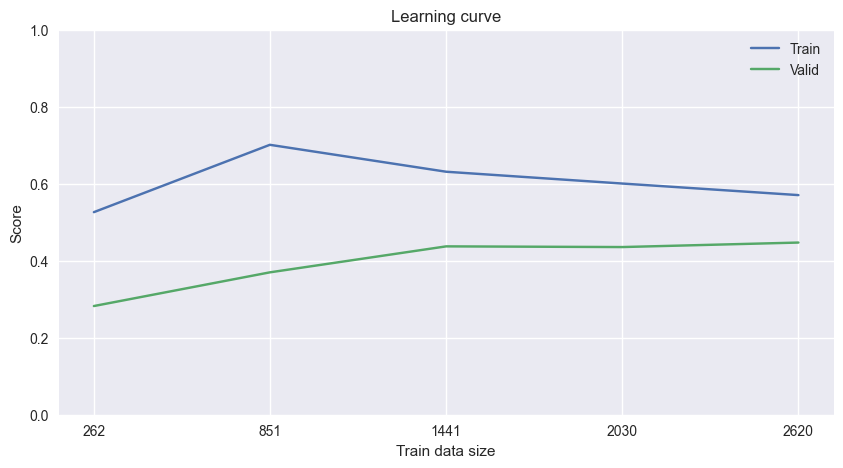

In [6]:
# Теперь можно построить графики кривых обучения:

#Визуализируем кривую обучения
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим кривую обучения по метрикам на тренировочных фолдах
ax.plot(train_sizes, train_scores_mean, label='Train')
#Строим кривую обучения по метрикам на валидационных фолдах
ax.plot(train_sizes, valid_scores_mean, label='Valid')
#Даём название графику и подписи осям
ax.set_title('Learning curve')
ax.set_xlabel('Train data size')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси абсцисс
ax.xaxis.set_ticks(train_sizes)
#Устаналиваем диапазон оси ординат
ax.set_ylim(0, 1)
#Отображаем легенду
ax.legend();

In [7]:
# Для удобства дальнейшего использования описанных выше действий для построения кривой обучения давайте обернём их в 
# функцию plot_learning_curve(). У функции будет несколько аргументов: модель, набор данных (X, y), кросс-валидатор, 
# метрика, координатная плоскость matplotlib, на которой будет строиться график, и подпись графика:

def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring=scoring,  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))  # фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 1)
    # Отображаем легенду
    ax.legend()

Теперь, когда у нас есть наша функция, давайте построим кривые обучения для нескольких моделей. Будем использовать следующие модели:

- логистическую регрессию,
- дерево решений с ограниченной максимальной глубиной и количеством объектов в листе,
- дерево решений без ограничений.

In [20]:
# Создадим список, в котором будем хранить эти модели:

#Создаём список из моделей
models = [
    linear_model.LogisticRegression(
        max_iter=1000, #количество итераций на сходимость
        random_state=42, #генератор случайных чисел
        class_weight='balanced' #веса классов
    ),
    tree.DecisionTreeClassifier(
        criterion='entropy', #критерий информативности
        max_depth=7, #максимальная глубина
        min_samples_leaf=5, #минимальное число объектов в листе
        random_state=42, #генератор случайных чисел 
        class_weight='balanced' #веса классов
    ),
    tree.DecisionTreeClassifier(
        criterion='entropy', #критерий информативности
        random_state=42, #генератор случайных чисел 
        class_weight='balanced' #веса классов
    ),
]

ValueError: 
All the 25 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\spbda\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\spbda\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\spbda\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1201, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\spbda\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\spbda\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py", line 1263, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "c:\Users\spbda\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py", line 1049, in check_array
    _assert_all_finite(
  File "c:\Users\spbda\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py", line 126, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "c:\Users\spbda\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py", line 175, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


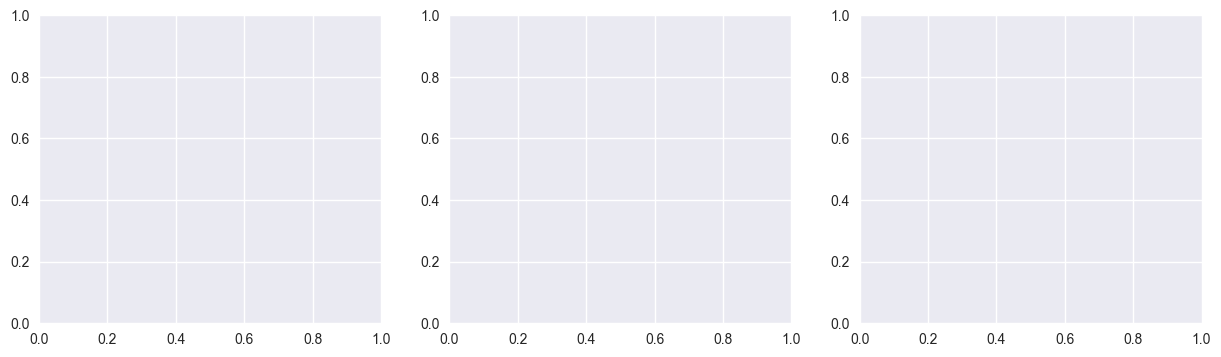

In [22]:
# Наконец, построим кривые обучения для каждой из моделей. Для этого заранее создадим k-fold-кросс-валидатор со 
# стратификацией на пять фолдов. Создадим фигуру с тремя координатными плоскостями. Реализуем цикл по составленному 
# списку из моделей и их индексам (они нам понадобятся для отображения на соответствующих координатных плоскостях). 
# Внутри цикла будем вызывать нашу функцию plot_learning_curve():

#Создаем объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Визуализируем кривые обучения
fig, axes = plt.subplots(1, 3, figsize=(15, 4)) #фигура + 3 координатных плоскости
#Создаем цикл по списку моделей и индексам этого списка
for i, model in enumerate(models): #i-текущий индекс, model - текущая модель
    plot_learning_curve(
        model, X, y, 
        skf, 
        ax=axes[i], 
        title=model.__class__.__name__ + '()'
)